In [382]:
import matplotlib.pyplot as plt
from erddapClient import ERDDAP_Griddap
from netCDF4 import Dataset
from matplotlib import colormaps
from pathlib import Path
import numpy as np
import xarray as xr
from pycurrents.file.binfile_n import BinfileSet


In [383]:
def arrayrbins(files):
    mat = list()
    for i in files:
        tmp = BinfileSet(str(i))
        mat.append(tmp.array)
    mat = np.vstack(mat)
    return(mat) 

def readrbins(pth, sensor, tag):
    tag = "*" + tag + "*.rbin"
    files = sorted(Path(pth+sensor+"/").glob(tag))
    mat = arrayrbins(files)

    #cols = BinfileSet(str(files[0])).columns
    mat = np.array(mat) #, dtype=cols)
    return(mat)

In [384]:
# grab mask from other data set.
file_id = Dataset('/home/jamie/projects/rogerrevelle/data/cmems_obs-sl_glo_phy-ssh_nrt_allsat-l4-duacs-0.25deg_P1D_1717864614312.nc')
ras = file_id.variables["sla"][:]
vgos = file_id.variables["vgos"][:]
ugos = file_id.variables["ugos"][:]
lat = file_id.variables["latitude"][:]
lon = file_id.variables["longitude"][:]
file_id.close()

# grab mask from other data set. 
file_id = Dataset('/home/jamie/projects/rogerrevelle/data/noaacwBLENDEDsstDNDaily_e5b2_b4c7_9276_U1717797277907.nc')
mask = file_id.variables["mask"][:]
lat_m = file_id.variables["latitude"][:]
lon_m = file_id.variables["longitude"][:]
file_id.close()

In [385]:
# get gps location
# sea = readrbins(pth ='/home/jamie/projects/atlantic_sst/', sensor = 'seapath380', tag = 'gps')
sea = readrbins(pth ='/mnt/revelle-data/RR2407/adcp_uhdas/RR2407/rbin/', sensor = 'seapath380', tag = 'gps')
gyro = readrbins(pth ='/mnt/revelle-data/RR2407/adcp_uhdas/RR2407/rbin/', sensor = 'gyro', tag = 'hdg')

In [386]:
ras = xr.DataArray(ras[0,:,:], 
                       coords={'x': lat, 'y':lon}, 
                       dims=["x", "y"])

mask = xr.DataArray(mask[0,:,:], 
                       coords={'x': lat_m, 'y':lon_m}, 
                       dims=["x", "y"])
mask = mask.where(mask.values != 1)

In [387]:
vgos= xr.DataArray(vgos[0,:,:], 
                       coords={'x': lat, 'y':lon}, 
                       dims=["x", "y"])
ugos= xr.DataArray(ugos[0,:,:], 
                       coords={'x': lat, 'y':lon}, 
                       dims=["x", "y"])

In [388]:
# PIES locations
swot_pos = np.column_stack(([-74.3666, -74.5339, -74.1932, -74.6728, -74.3657, -74.2781], 
                           [36.2333, 35.9997, 36.0069, 36.0001, 36.0012, 35.7561]))
swot_pos = np.array(swot_pos)
pioneer_pos = np.column_stack(([-74.705, -74.7633], [36.050, 35.700]))
pioneer_pos = np.array(pioneer_pos)

# pull out most regent heading and convert to radians. 
theta = gyro[-1,1] *(np.pi/180) # to radians
pos = sea[-1]
prev_pos = sea[-100:-1]

In [389]:
min_lon = pos[2] - 1
min_lat = pos[3] - 1 
max_lon = pos[2] + 1
max_lat = pos[3] + 1

mask_lon = (ras.y >= min_lon) & (ras.y <= max_lon)
mask_lat = (ras.x >= min_lat) & (ras.x <= max_lat)

ras_cut = ras.where(mask_lon & mask_lat, drop=True)
mask_cut = mask.where(mask_lon & mask_lat, drop=True)

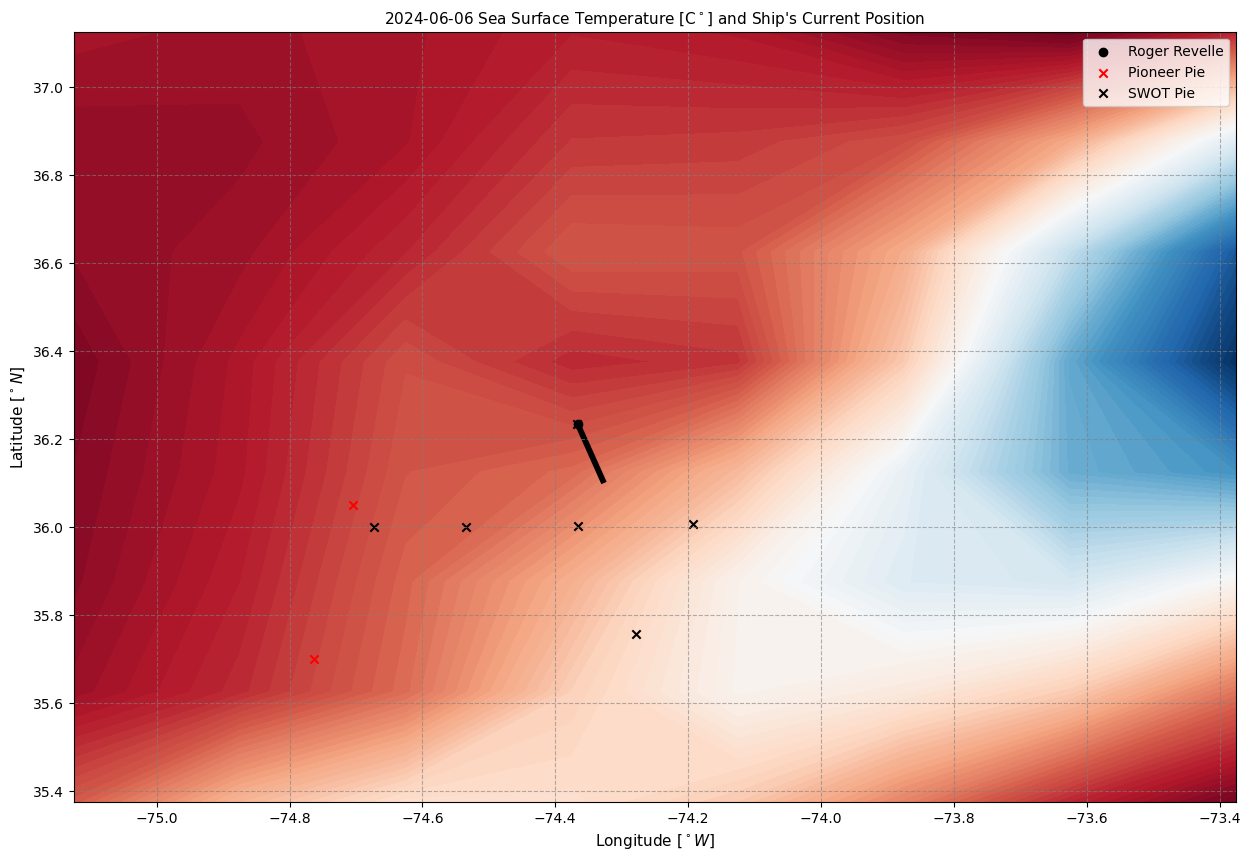

In [390]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
ax1.contourf(mask_cut.y, mask_cut.x, mask_cut[:,:], cmap = "binary")
ax1.contourf(ras_cut.y, ras_cut.x, ras_cut[:, :], 100, cmap = "RdBu")
# Once I have position I should be fine with heading from the gyro. 
ax1.grid(color = "grey", linestyle = '--', alpha = 0.6)# visible=None)
#c = ax1.contourf(lon[lon_idx], lat[lat_idx], sst[0, lat_idx, lon_idx], 100, cmap = "coolwarm")
#cbar = fig.colorbar(c)
ax1.quiver(pos[2], pos[3], np.cos(theta), np.sin(theta), headlength=0.0001, headaxislength=0.0001, width = 0.005)
ax1.scatter(pos[2], pos[3], color = "black",  label='Roger Revelle')
ax1.scatter(pioneer_pos[:,0], pioneer_pos[:,1], color = "red", marker = 'x', label='Pioneer Pie')
ax1.scatter(swot_pos[:,0], swot_pos[:,1], color = "black", marker = 'x', label = 'SWOT Pie')
ax1.scatter(prev_pos[:,2], prev_pos[:,3], marker = ',', color = "black", s = 0.5, alpha = 0.5)
# cbar.set_label("Sea Surface Temperature [C$^\circ$]")
ax1.set_xlabel("Longitude [$^\circ W$]", size = 11)
ax1.set_ylabel("Latitude [$^\circ N$]", size = 11)
ax1.set_title("2024-06-06 Sea Surface Temperature [C$^\circ$] and Ship's Current Position", size = 11)
ax1.legend()
plt.savefig('test.pdf', dpi=300);
plt.show()  

In [391]:
#vmin = -0.6
#vmax = 0.8
#levels = np.linspace(vmin, vmax, 100+1)
#ras = ras.clip(vmin, vmax)

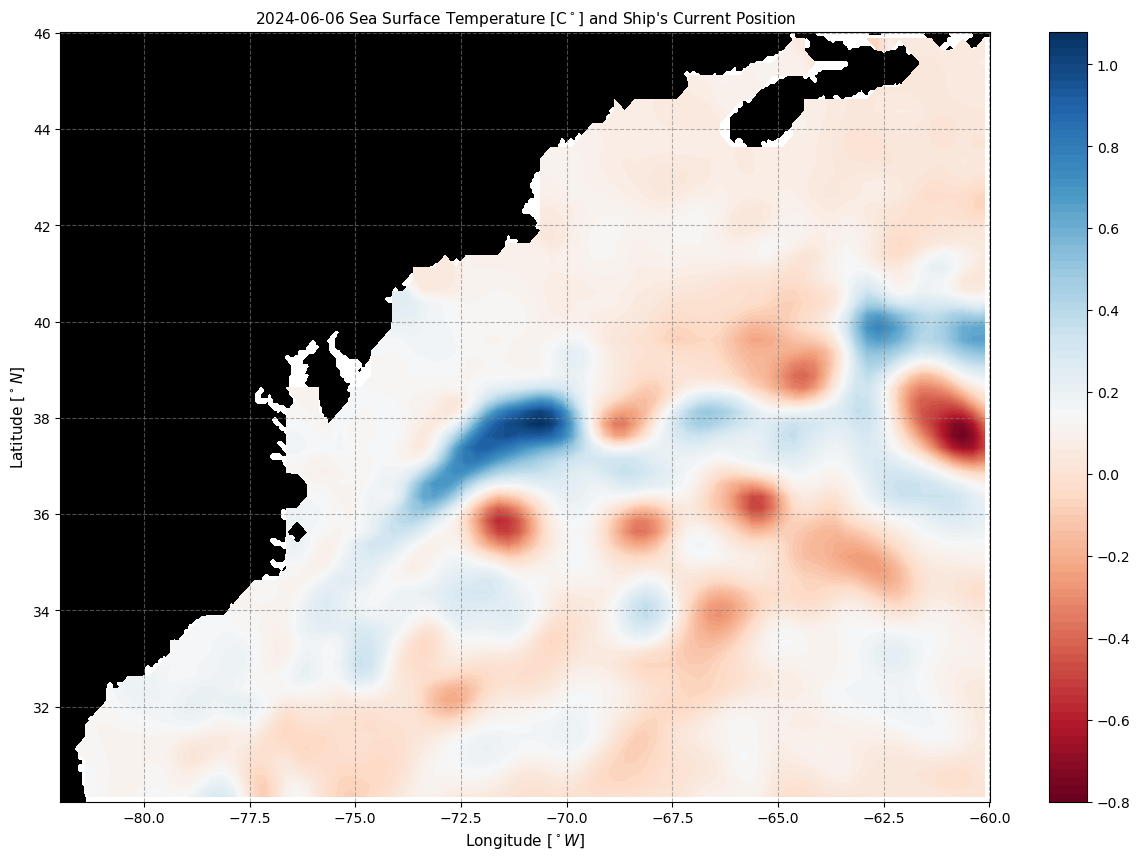

In [394]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
ax1.contourf(ras.y, ras.x, ras[:, :], 100, cmap = "RdBu")
ax1.contourf(mask.y, mask.x, mask[:,:], 1, colors = "black")
# Once I have position I should be fine with heading from the gyro. 
ax1.grid(color = "grey", linestyle = '--', alpha = 0.6)# visible=None)
c = ax1.contourf(ras.y, ras.x, ras[:, :], 100, cmap = "RdBu")
cbar = fig.colorbar(c)
#ax1.quiver(pos[2], pos[3], np.cos(theta), np.sin(theta), headlength=0.0001, headaxislength=0.0001, width = 0.005)
#ax1.scatter(pos[2], pos[3], color = "black")
#ax1.scatter(prev_pos[:,2], prev_pos[:,3], marker = ',', color = "black", s = 0.5, alpha = 0.5)
#ax1.scatter(pioneer_pos[:,0], pioneer_pos[:,1], color = "red", marker = 'x')
#ax1.scatter(swot_pos[:,0], swot_pos[:,1], color = "black", marker = 'x')
# cbar.set_label("Sea Surface Temperature [C$^\circ$]")
ax1.set_xlabel("Longitude [$^\circ W$]", size = 11)
ax1.set_ylabel("Latitude [$^\circ N$]", size = 11)
ax1.set_title("2024-06-06 Sea Surface Temperature [C$^\circ$] and Ship's Current Position", size = 11);
plt.show()

AttributeError: 'MaskedArray' object has no attribute 'x'

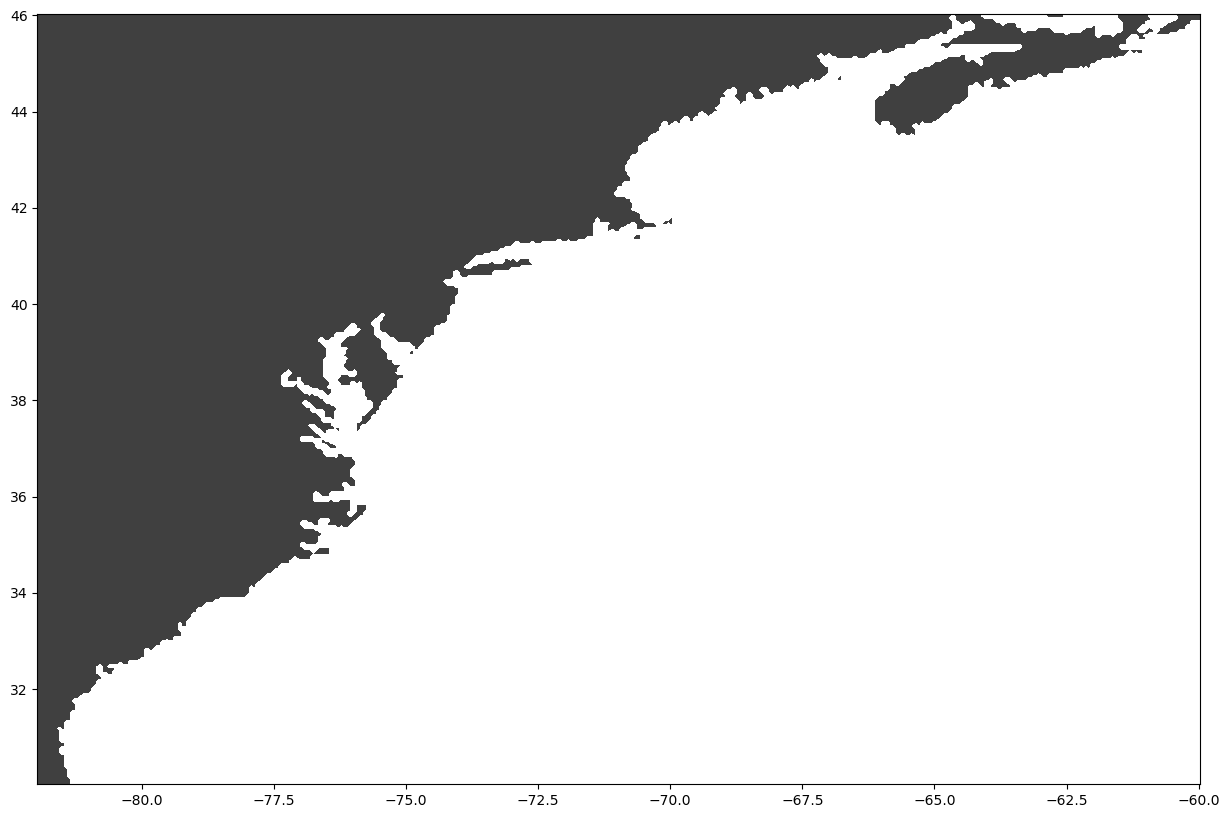

In [353]:
fig, (ax1) = plt.subplots(1, 1, figsize=(15, 10))
ax1.contourf(mask.y, mask.x, mask[:,:], cmap = "gray")
ax1.contourf(ras.y, vgos.x, ras[:, :], 100, cmap = "RdBu")
# Once I have position I should be fine with heading from the gyro. 
ax1.grid(color = "grey", linestyle = '--', alpha = 0.6)# visible=None)
#c = ax1.contourf(lon, lat, sst[0,:,:], 100, cmap = "coolwarm")
#cbar = fig.colobar(c)
ax1.quiver(ugos.y, ugos.x, vgos[:, :], ugos[:,:])
# headlength=0.0001, headaxislength=0.0001, width = 0.005
#ax1.scatter(pos[2], pos[3], color = "black")
#ax1.scatter(prev_pos[:,2], prev_pos[:,3], marker = ',', color = "black", s = 0.5, alpha = 0.5)
#ax1.scatter(pioneer_pos[:,0], pioneer_pos[:,1], color = "red", marker = 'x')
#ax1.scatter(swot_pos[:,0], swot_pos[:,1], color = "black", marker = 'x')
# cbar.set_label("Sea Surface Temperature [C$^\circ$]")
ax1.set_xlabel("Longitude [$^\circ W$]", size = 11)
ax1.set_ylabel("Latitude [$^\circ N$]", size = 11)
ax1.set_title("2024-06-06 Sea Surface Temperature [C$^\circ$] and Ship's Current Position", size = 11);
plt.show()